In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *
import h5py
from holotomocupy.proc import remove_outliers




astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension

npos = 16  # number of code positions
detector_pixelsize = 3.03751e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:1]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'1'
path = f'/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01/'

## Read data

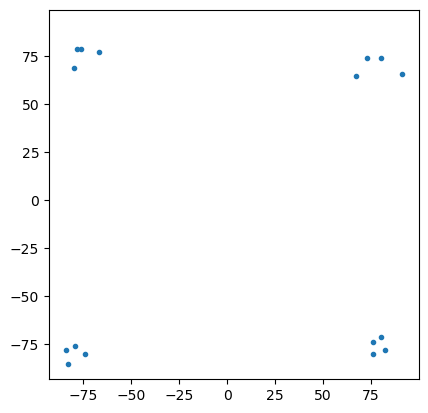

/tmp/ipykernel_866673/560253413.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])


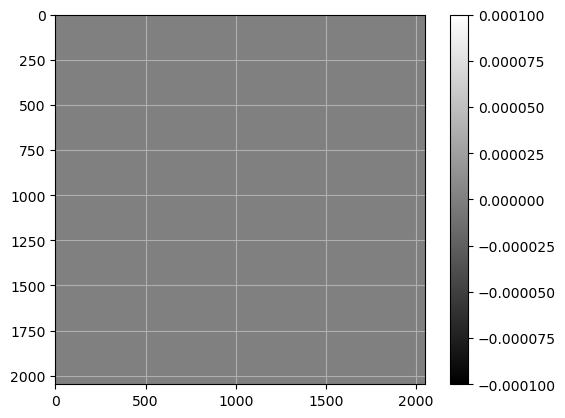

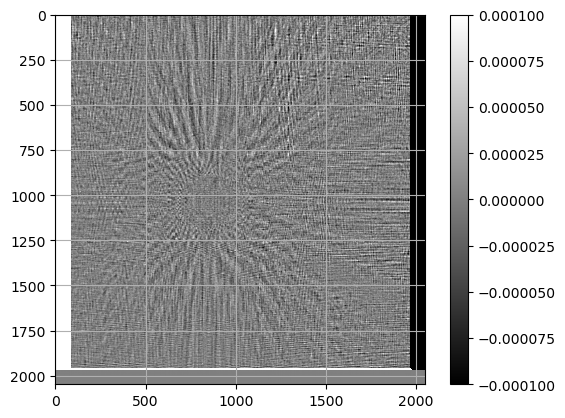

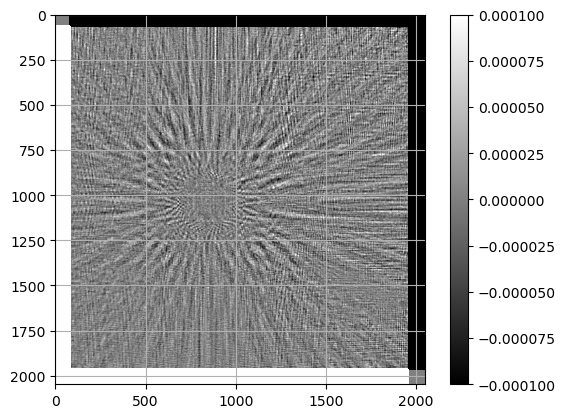

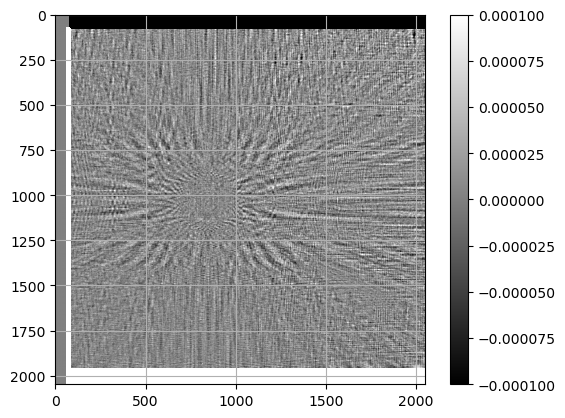

0


In [3]:
nref = 20
ndark = 20
data00 = np.zeros([1,npos,n,n],dtype='float32')
ref00 = np.zeros([nref,n,n],dtype='float32')
dark00 = np.zeros([ndark,n,n],dtype='float32')
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    data00[:] = fid['/entry_0000/measurement/data'][:npos][np.newaxis]
with h5py.File(f'{path}/ref_0000.h5','r') as fid:
    ref00[:]=fid['/entry_0000/measurement/data'][:nref]
with h5py.File(f'{path}/dark_0000.h5','r') as fid:
    dark00[:]=fid['/entry_0000/measurement/data'][:ndark]
with h5py.File(f'{path}SiemensLH_33keV_010nm_holoNfpScan_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

plt.plot(spy,spz,'.')
plt.axis('square')
plt.show()
shifts_code = np.zeros([1,npos,2],dtype='float32')
shifts_code[:,:,1] = spy
shifts_code[:,:,0] = -spz

for k in range(npos):
    radius = 7
    threshold = 20000
    data00[:,k] = remove_outliers(data00[:,k], radius, threshold)
ref00[:] = remove_outliers(ref00[:], radius, threshold)     


data00-=np.mean(dark00)
ref00-=np.mean(dark00)

data00[data00<=0] = 0
ref00[ref00<=0] = 0

data00/=np.mean(ref00)
ref00/=np.mean(ref00)

rdata = (data00-np.mean(dark00,axis=0))/(np.mean(ref00,axis=0)-np.mean(dark00,axis=0))

for k in range(npos):
    rdata[:,k] = ST(rdata[:,k],shifts_code[:,k])

for k in range(0,npos,4):
    plt.imshow(rdata[0,k]-rdata[0,0],cmap='gray',vmin=-1e-4,vmax=1e-4)
    plt.grid('on')
    plt.colorbar()
    plt.show()


print(np.sum(np.isnan(data00)))
dxchange.write_tiff(data00[0],'/data/tmp')


# Construct operators


In [4]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')



(126722432-4.293596267700195j)==
(126722432-2.5500974595860093e-11j)
(83319360-0.2890625j)==
(83319368+4.143296246184036e-05j)


### Divide by reference image for 1step Paganin reconsturction

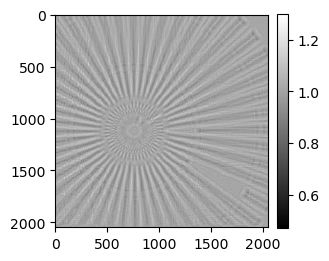

In [5]:
ref0 = cp.array(cp.mean(ref00,axis=0))[np.newaxis,np.newaxis]
data00 = cp.array(data00)
rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=1.3)

/tmp/ipykernel_866673/2228664114.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_866673/2228664114.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


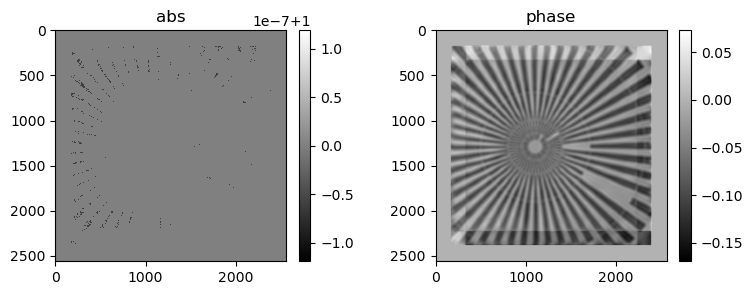

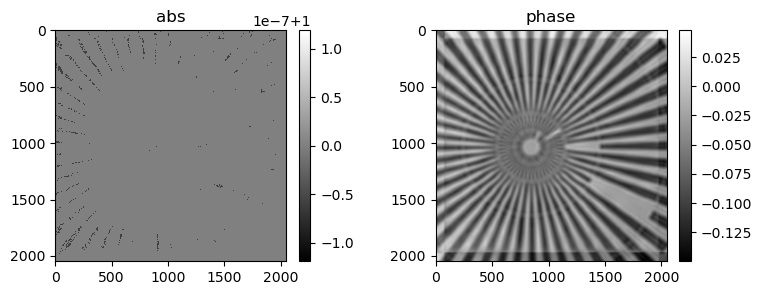

In [6]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 9e-3)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


#### Reconstruction with the CG (Carlsson) with Hessians

0) gammah=array(0.02000448, dtype=float32), err=3.94797e+05


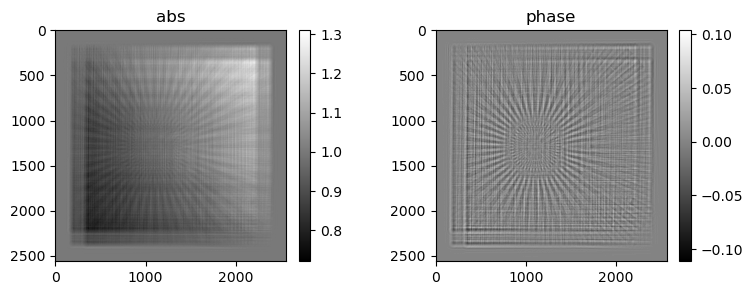

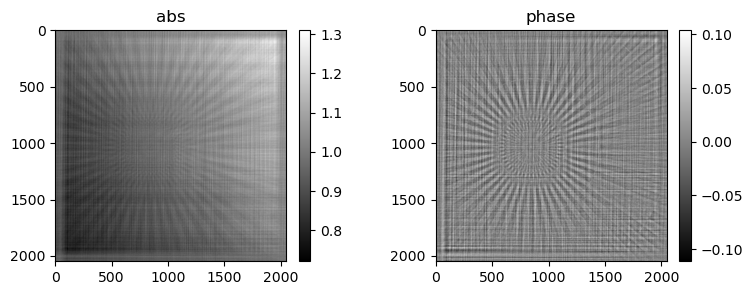

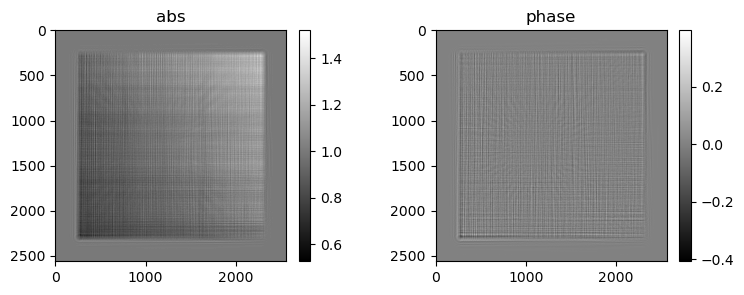

1) gammah=array(0.0240576, dtype=float32), err=7.29653e+04
2) gammah=array(0.02423153, dtype=float32), err=3.20965e+04
3) gammah=array(0.02711774, dtype=float32), err=2.19239e+04
4) gammah=array(0.03773374, dtype=float32), err=1.86735e+04
5) gammah=array(0.04276204, dtype=float32), err=1.69302e+04
6) gammah=array(0.04014212, dtype=float32), err=1.57830e+04
7) gammah=array(0.04549477, dtype=float32), err=1.48371e+04
8) gammah=array(0.04737739, dtype=float32), err=1.41248e+04
9) gammah=array(0.04600984, dtype=float32), err=1.35614e+04
10) gammah=array(0.04708197, dtype=float32), err=1.31168e+04
11) gammah=array(0.05120193, dtype=float32), err=1.26988e+04
12) gammah=array(0.05277792, dtype=float32), err=1.22758e+04
13) gammah=array(0.05606332, dtype=float32), err=1.18254e+04
14) gammah=array(0.05404304, dtype=float32), err=1.13781e+04
15) gammah=array(0.04897944, dtype=float32), err=1.09419e+04
16) gammah=array(0.04756398, dtype=float32), err=1.05398e+04
17) gammah=array(0.0474695, dtype=

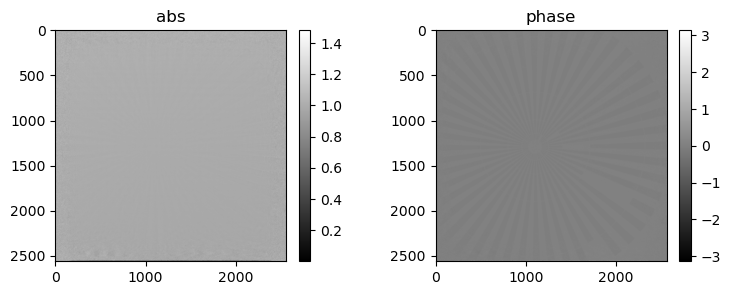

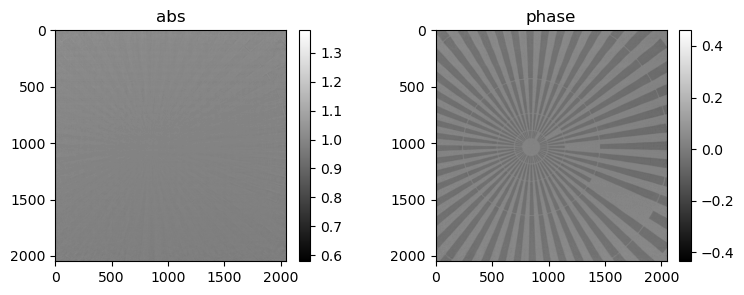

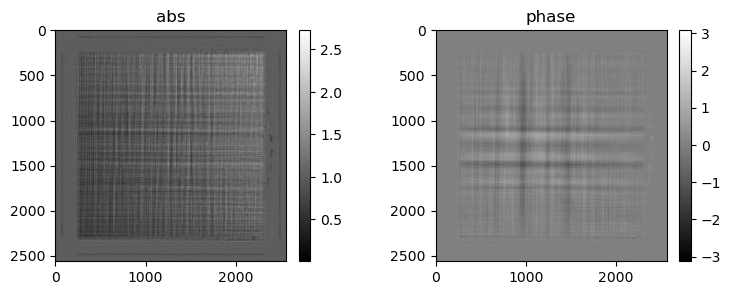

257) gammah=array(0.04915137, dtype=float32), err=3.99846e+03
258) gammah=array(0.04921776, dtype=float32), err=3.99644e+03
259) gammah=array(0.04936067, dtype=float32), err=3.99444e+03
260) gammah=array(0.04877508, dtype=float32), err=3.99247e+03
261) gammah=array(0.04904792, dtype=float32), err=3.99051e+03
262) gammah=array(0.04883915, dtype=float32), err=3.98856e+03
263) gammah=array(0.04926546, dtype=float32), err=3.98663e+03
264) gammah=array(0.04911026, dtype=float32), err=3.98472e+03
265) gammah=array(0.04925052, dtype=float32), err=3.98282e+03
266) gammah=array(0.04868631, dtype=float32), err=3.98094e+03
267) gammah=array(0.0491051, dtype=float32), err=3.97908e+03
268) gammah=array(0.04882109, dtype=float32), err=3.97723e+03
269) gammah=array(0.04887316, dtype=float32), err=3.97541e+03
270) gammah=array(0.04864391, dtype=float32), err=3.97359e+03
271) gammah=array(0.04949117, dtype=float32), err=3.97178e+03
272) gammah=array(0.04903831, dtype=float32), err=3.96999e+03
273) gamm

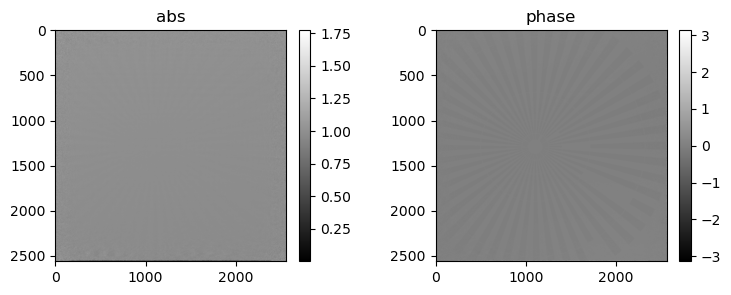

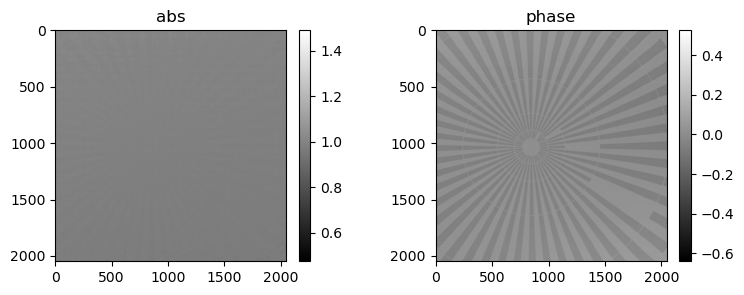

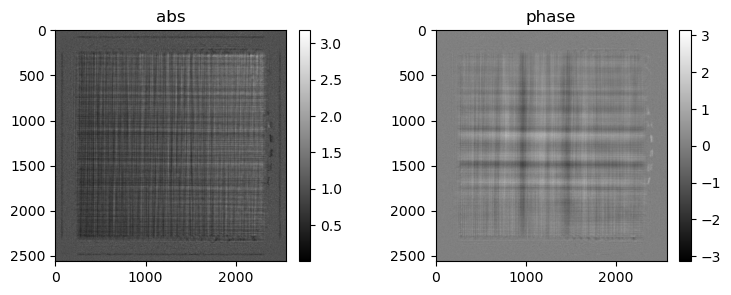

513) gammah=array(0.047955, dtype=float32), err=3.74933e+03
514) gammah=array(0.04763683, dtype=float32), err=3.74884e+03
515) gammah=array(0.04806675, dtype=float32), err=3.74835e+03
516) gammah=array(0.04780804, dtype=float32), err=3.74787e+03
517) gammah=array(0.04820042, dtype=float32), err=3.74738e+03
518) gammah=array(0.04788409, dtype=float32), err=3.74690e+03
519) gammah=array(0.04805913, dtype=float32), err=3.74642e+03
520) gammah=array(0.04770723, dtype=float32), err=3.74594e+03
521) gammah=array(0.04790107, dtype=float32), err=3.74546e+03
522) gammah=array(0.04776828, dtype=float32), err=3.74498e+03
523) gammah=array(0.04811085, dtype=float32), err=3.74451e+03
524) gammah=array(0.04751891, dtype=float32), err=3.74404e+03
525) gammah=array(0.04771144, dtype=float32), err=3.74357e+03
526) gammah=array(0.04777042, dtype=float32), err=3.74310e+03
527) gammah=array(0.04821375, dtype=float32), err=3.74263e+03
528) gammah=array(0.04771837, dtype=float32), err=3.74216e+03
529) gamma

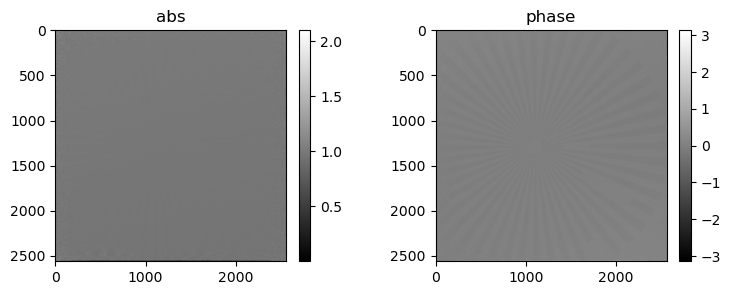

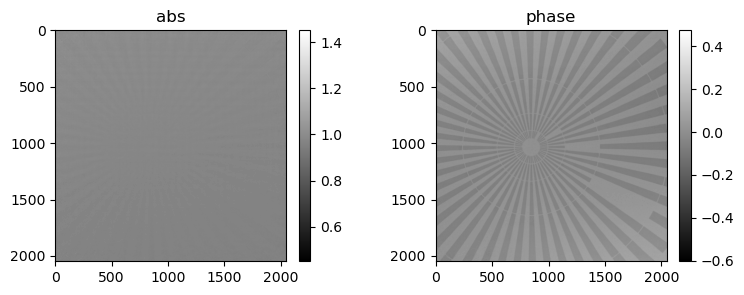

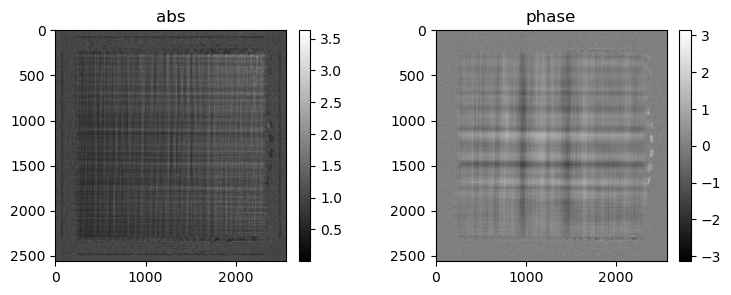

769) gammah=array(0.04672047, dtype=float32), err=3.66055e+03
770) gammah=array(0.04648748, dtype=float32), err=3.66030e+03
771) gammah=array(0.0468706, dtype=float32), err=3.66005e+03
772) gammah=array(0.04678111, dtype=float32), err=3.65980e+03
773) gammah=array(0.04679447, dtype=float32), err=3.65955e+03
774) gammah=array(0.04641669, dtype=float32), err=3.65930e+03
775) gammah=array(0.04654629, dtype=float32), err=3.65905e+03
776) gammah=array(0.04656991, dtype=float32), err=3.65880e+03
777) gammah=array(0.04678048, dtype=float32), err=3.65855e+03
778) gammah=array(0.04640708, dtype=float32), err=3.65830e+03
779) gammah=array(0.04667202, dtype=float32), err=3.65805e+03
780) gammah=array(0.04669206, dtype=float32), err=3.65781e+03
781) gammah=array(0.04683964, dtype=float32), err=3.65756e+03
782) gammah=array(0.04655871, dtype=float32), err=3.65731e+03
783) gammah=array(0.04668642, dtype=float32), err=3.65707e+03
784) gammah=array(0.04637766, dtype=float32), err=3.65682e+03
785) gamm

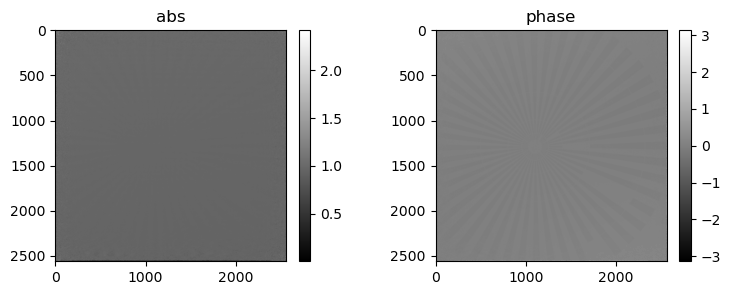

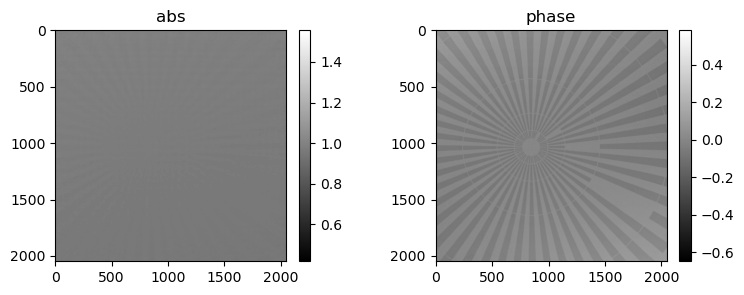

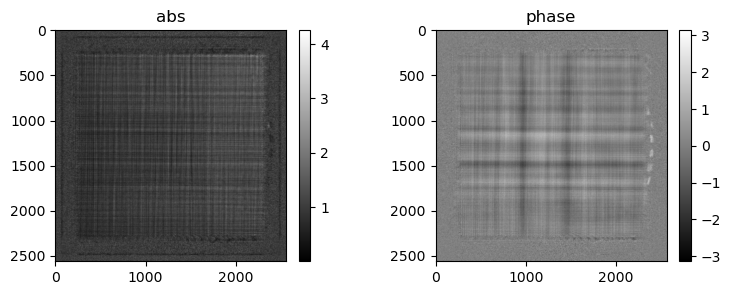

1025) gammah=array(0.04569647, dtype=float32), err=3.60787e+03
1026) gammah=array(0.04563113, dtype=float32), err=3.60770e+03
1027) gammah=array(0.04583625, dtype=float32), err=3.60753e+03
1028) gammah=array(0.04570443, dtype=float32), err=3.60736e+03
1029) gammah=array(0.04572858, dtype=float32), err=3.60719e+03
1030) gammah=array(0.04567475, dtype=float32), err=3.60702e+03
1031) gammah=array(0.04573035, dtype=float32), err=3.60685e+03
1032) gammah=array(0.04553396, dtype=float32), err=3.60668e+03
1033) gammah=array(0.04567305, dtype=float32), err=3.60651e+03
1034) gammah=array(0.04565125, dtype=float32), err=3.60634e+03
1035) gammah=array(0.04574377, dtype=float32), err=3.60617e+03
1036) gammah=array(0.04552927, dtype=float32), err=3.60601e+03
1037) gammah=array(0.04569744, dtype=float32), err=3.60584e+03
1038) gammah=array(0.04569225, dtype=float32), err=3.60567e+03
1039) gammah=array(0.04583076, dtype=float32), err=3.60550e+03
1040) gammah=array(0.04567835, dtype=float32), err=3.60

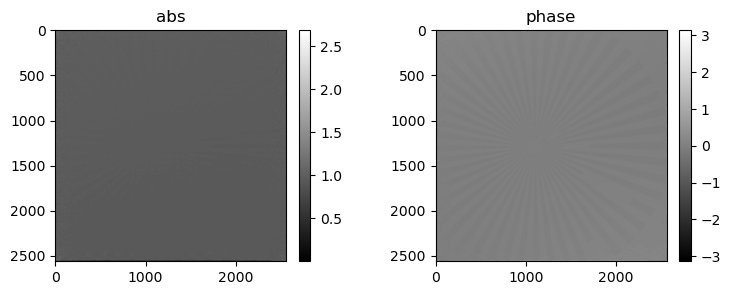

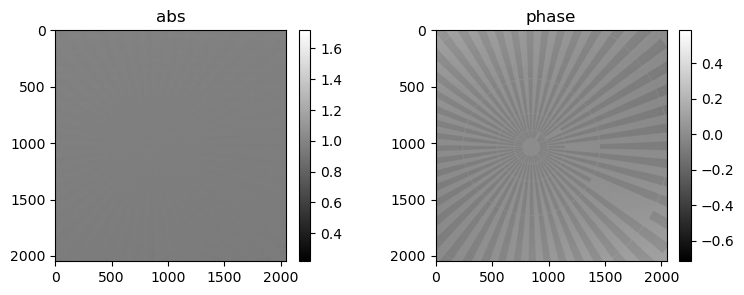

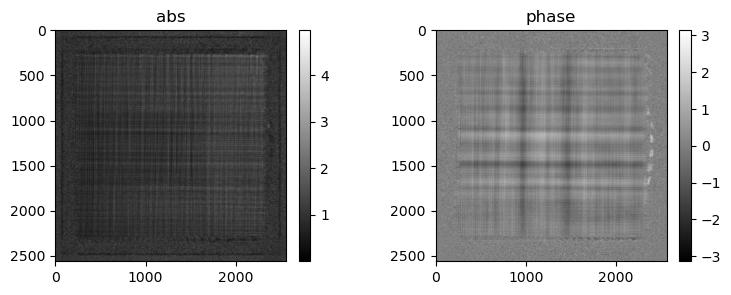

1281) gammah=array(0.04500151, dtype=float32), err=3.56960e+03
1282) gammah=array(0.04482795, dtype=float32), err=3.56947e+03
1283) gammah=array(0.04496691, dtype=float32), err=3.56934e+03
1284) gammah=array(0.04482743, dtype=float32), err=3.56921e+03
1285) gammah=array(0.04485266, dtype=float32), err=3.56908e+03
1286) gammah=array(0.04473405, dtype=float32), err=3.56895e+03
1287) gammah=array(0.04490026, dtype=float32), err=3.56882e+03
1288) gammah=array(0.0449379, dtype=float32), err=3.56869e+03
1289) gammah=array(0.04509297, dtype=float32), err=3.56856e+03
1290) gammah=array(0.04487224, dtype=float32), err=3.56843e+03
1291) gammah=array(0.04484007, dtype=float32), err=3.56830e+03
1292) gammah=array(0.04469607, dtype=float32), err=3.56817e+03
1293) gammah=array(0.04492332, dtype=float32), err=3.56804e+03
1294) gammah=array(0.04481815, dtype=float32), err=3.56790e+03
1295) gammah=array(0.0449011, dtype=float32), err=3.56777e+03
1296) gammah=array(0.04482186, dtype=float32), err=3.5676

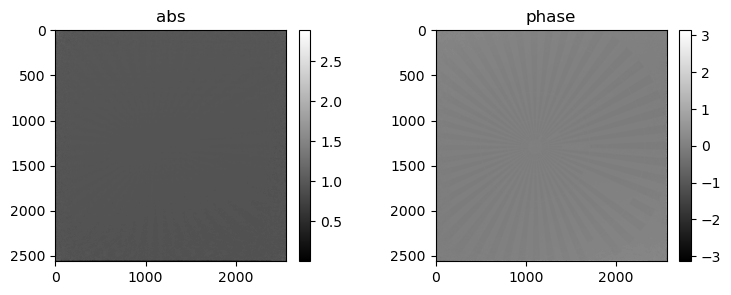

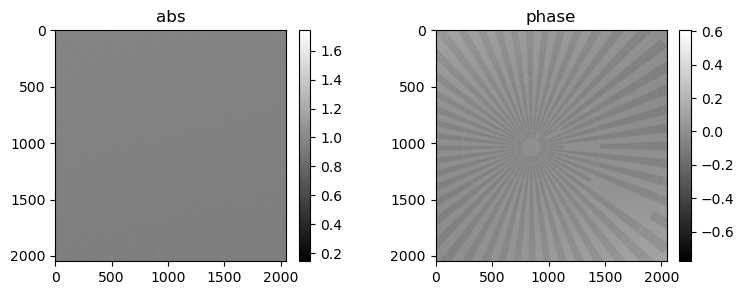

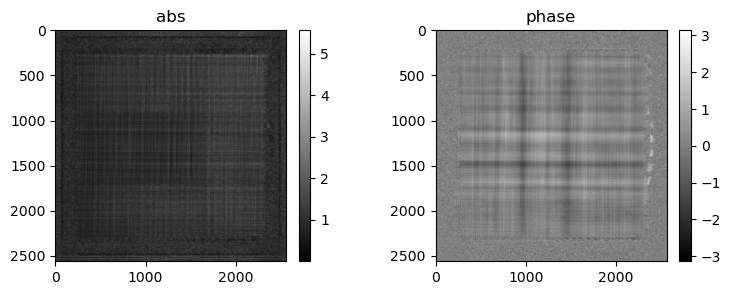

1537) gammah=array(0.04406921, dtype=float32), err=3.53929e+03
1538) gammah=array(0.04409726, dtype=float32), err=3.53918e+03
1539) gammah=array(0.0442373, dtype=float32), err=3.53907e+03
1540) gammah=array(0.04400781, dtype=float32), err=3.53897e+03
1541) gammah=array(0.04405988, dtype=float32), err=3.53886e+03
1542) gammah=array(0.04393704, dtype=float32), err=3.53875e+03
1543) gammah=array(0.04408805, dtype=float32), err=3.53865e+03
1544) gammah=array(0.04396129, dtype=float32), err=3.53854e+03
1545) gammah=array(0.04403691, dtype=float32), err=3.53843e+03
1546) gammah=array(0.04400318, dtype=float32), err=3.53833e+03
1547) gammah=array(0.04409612, dtype=float32), err=3.53822e+03
1548) gammah=array(0.04399855, dtype=float32), err=3.53811e+03
1549) gammah=array(0.04402719, dtype=float32), err=3.53801e+03
1550) gammah=array(0.04392543, dtype=float32), err=3.53790e+03
1551) gammah=array(0.04417562, dtype=float32), err=3.53780e+03
1552) gammah=array(0.04400286, dtype=float32), err=3.537

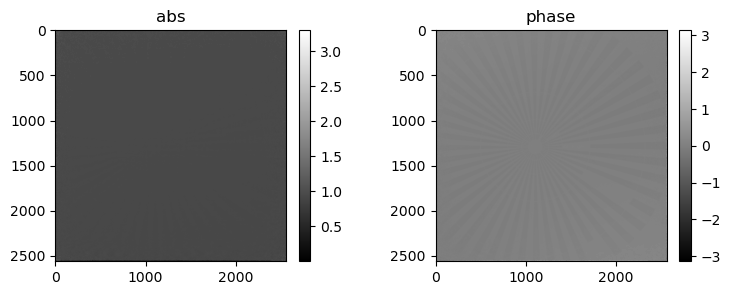

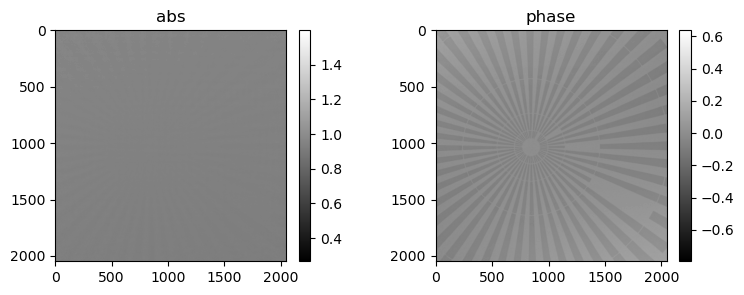

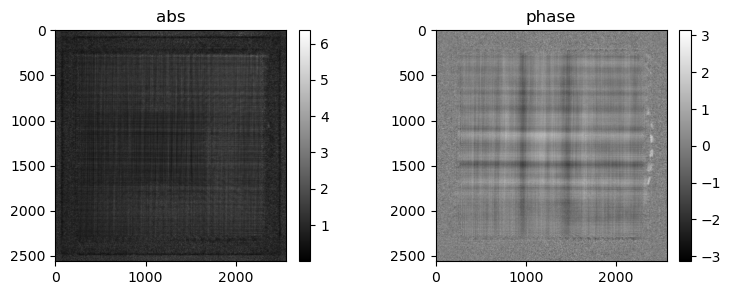

1793) gammah=array(0.0418456, dtype=float32), err=3.51423e+03
1794) gammah=array(0.04156179, dtype=float32), err=3.51414e+03
1795) gammah=array(0.04102053, dtype=float32), err=3.51406e+03
1796) gammah=array(0.0410051, dtype=float32), err=3.51397e+03
1797) gammah=array(0.04112182, dtype=float32), err=3.51388e+03
1798) gammah=array(0.04168501, dtype=float32), err=3.51379e+03
1799) gammah=array(0.04188781, dtype=float32), err=3.51370e+03
1800) gammah=array(0.0422267, dtype=float32), err=3.51361e+03
1801) gammah=array(0.04205374, dtype=float32), err=3.51352e+03
1802) gammah=array(0.04200079, dtype=float32), err=3.51344e+03
1803) gammah=array(0.0415292, dtype=float32), err=3.51335e+03
1804) gammah=array(0.04113602, dtype=float32), err=3.51326e+03
1805) gammah=array(0.04064748, dtype=float32), err=3.51317e+03
1806) gammah=array(0.04078762, dtype=float32), err=3.51309e+03
1807) gammah=array(0.04109441, dtype=float32), err=3.51300e+03
1808) gammah=array(0.04180894, dtype=float32), err=3.51291e

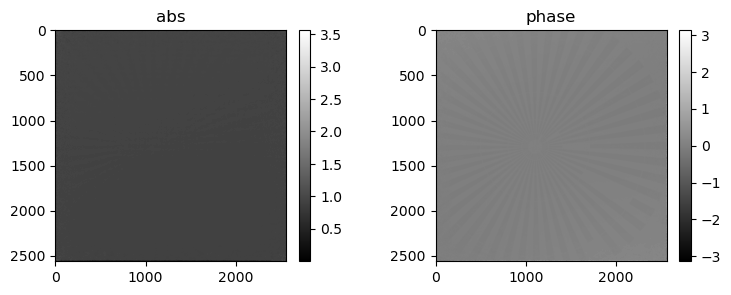

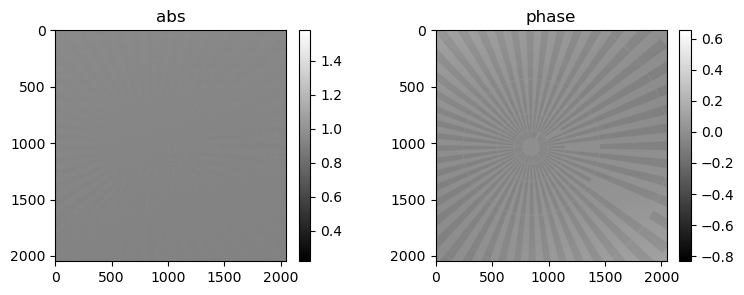

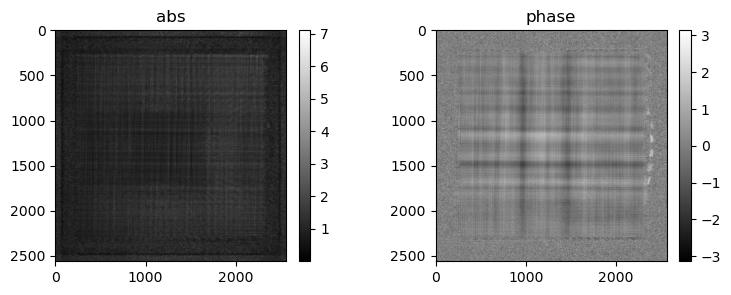

In [8]:
def hessian2(hpsi,hksi,heta,data):
    Lksi = Lop(hksi)
    Leta = Lop(heta)
    Lpsi = Lop(hpsi)        

    v1 = cp.abs(Lpsi)-data
    v2 = cp.real(cp.conj(Lksi)*Leta)/cp.abs(Lpsi)            
    v3 = cp.real(cp.conj(Lpsi)*Lksi) * cp.real(cp.conj(Lpsi)*Leta) / cp.abs(Lpsi)**3        
    return 2*(cp.sum(v1 * cp.conj(v2)) + cp.sum(data*cp.conj(v3)))

def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)

    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])
    
   
        
    for i in range(pars['niter']):                                        
        
        fpsi = Lop(Sop(psi)*prb)
                
        gradx = 2*LTop(fpsi-data*np.exp(1j*np.angle(fpsi)))                                
        
        gradpsi = STop(gradx*cp.conj(prb))             
        
        gradprb = gradx*cp.conj(Sop(psi))
        gradprb = cp.sum(gradprb,axis=1)        

#        etapsi = -gradpsi
 #       etaprb = -gradprb
        if i==0:
            etapsi = -gradpsi
            etaprb = -gradprb
        else:
            # top
            hpsi = Sop(psi)*prb            
            hksi = Sop(gradpsi)*prb+Sop(psi)*gradprb   
            heta = Sop(etapsi)*prb+Sop(psi)*etaprb                        

            h2u = hessian2(hpsi,hksi,heta,data)
            h2u += cp.real(cp.sum(gradx*cp.conj(Sop(gradpsi)*etaprb)))+ \
                   cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*gradprb)))
            
            # bottom
            hpsi = Sop(psi)*prb
            heta = Sop(etapsi)*prb+Sop(psi)*etaprb   
            h2b = hessian2(hpsi,heta,heta,data)
            h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))

            beta = h2u/h2b
            
            etapsi = -gradpsi + beta*etapsi
            etaprb = -gradprb + beta*etaprb

        #top
        top = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))-cp.sum(cp.real(gradprb*cp.conj(etaprb)))
        # bottom
        hpsi = Sop(psi)*prb
        heta = Sop(etapsi)*prb+Sop(psi)*etaprb  
        
        h2b = hessian2(hpsi,heta,heta,data)
        h2b += 2*cp.real(cp.sum(gradx*cp.conj(Sop(etapsi)*etaprb)))
        
        gammah = top/h2b 

        # npp = 17
        # errt = np.zeros(npp)
        # errt2 = np.zeros(npp)
        # if i>-1:
        #     for k in range(0,npp):
        #         psit = psi+(gammah*k/(npp-1))*etapsi
        #         prbt = prb+(gammah*k/(npp-1))*etaprb
        #         fpsit = Lop(Sop(psit)*prbt)
        #         errt[k] = minf(fpsit)    
        #     t = gammah*cp.arange(npp)/(npp-1)
        #     errt2 = minf(Lop(Sop(psi)*prb))-top*t+0.5*h2b*t**2
        #     plt.plot(gammah.get()*np.arange(17)/16,errt,'.')
        #     plt.plot(gammah.get()*np.arange(17)/16,errt2.get(),'.')
        #     plt.show()
        #     plt.plot(gammah.get()*np.arange(npp)/(npp-1),errt-errt2.get(),'.')
        #     plt.show()

        # print(f'{h2b=}, {gammah=}')
        psi += gammah*etapsi
        prb += gammah*etaprb

        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)
            err = minf(fpsi)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0],show)
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            mshow_polar(prb[0],show)

    return psi,prb,conv,gammaha

# fully on gpu
rec_psi = recMultiPaganin.copy()*0+1
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')#cp.array(rec_prb0.copy())*0+1#cp.abs(rec_prb0).astype('complex64')#*cp.exp().copy()
pars = {'niter':2049, 'err_step': 1, 'vis_step': 256}
rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb, pars)
k = f'cghessians'
np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
np.save(f'data/conv_{k}_{pars['niter']}',conv)
np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)



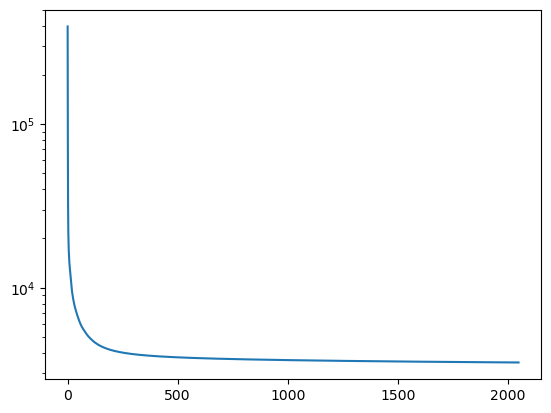

In [9]:
plt.plot(conv)
plt.yscale('log')

In [10]:
k = f'cghessians'
np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
np.save(f'data/conv_{k}_{pars['niter']}',conv)
np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)

In [13]:
dxchange.write_tiff(np.angle(rec_psi.get()),'/data/tmp/rec_psi',overwrite=True)
dxchange.write_tiff(np.angle(rec_prb.get()),'/data/tmp/rec_prb',overwrite=True)

: 

In [12]:
r = cp.array(np.load(f'{path}/data/code_{flg}.npy'))
nee = r.shape[1]
r = cp.array(r[:,nee//2-ne//2:nee//2+ne//2,nee//2-ne//2:nee//2+ne//2])

FileNotFoundError: [Errno 2] No such file or directory: '/data/vnikitin/ESRF/ID16A/SiemensLH_33keV_010nm_holoNfpScan_01//data/code_1.npy'

In [ ]:
crop = (rec_psi.shape[-1]-(3*n//2+2*pad))//2
plt.imshow(cp.angle(r[0,crop:-crop,crop:-crop]).get(),cmap='gray',vmax=0,vmin=-1)
plt.colorbar()
plt.show()
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get(),cmap='gray')#,vmax=0,vmin=-1)
plt.colorbar()
plt.show()

a = np.median(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get()-cp.angle(r[0,crop:-crop,crop:-crop]).get())
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get()-a,cmap='gray')#,vmax=0,vmin=-1)
plt.colorbar()
plt.show()
print(a)
plt.imshow(cp.angle(rec_psi[0,crop:-crop,crop:-crop]).get()-cp.angle(r[0,crop:-crop,crop:-crop]).get()-a,cmap='gray')#,vmax=-0.1,vmin=0.1)
plt.colorbar()
plt.show()

# np.save('data/rec_code',rec_psi.get())


In [ ]:
plt.loglog(conv)
plt.yscale('log')
plt.show()

rec_psis =rec_psi*cp.exp(-1j*a)
plt.imshow(np.angle(rec_psis[0,400:500,400:500]).get(),cmap='gray')
plt.colorbar()
np.save(f'/data2/vnikitin/coded_apertures_new3/data/code_rec_{flg}',rec_psis)

In [ ]:
rr = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))

#mshow_polar(rec_prb[0],show)
plt.imshow(cp.angle(rec_prb[0,100:-100,100:-100]).get(),vmin=-0.3,vmax=0.3,cmap='gray')
plt.show()
plt.imshow(cp.angle(rr[0,100:-100,100:-100]).get(),cmap='gray')
plt.show()

#mshow_polar(rr[0],show)